In [ ]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime


# Custom modules and packages
import params.siamese
import traversalcost.utils
from dataset import SiameseNetworkDataset
from model import SiameseNetwork
from loss import SiameseLoss
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

## Load learning parameters

In [ ]:
LEARNING_PARAMS = params.siamese.LEARNING

## Prepare data

In [ ]:
# Create a Dataset for training
train_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for validation
# (same as training here since no transformation is applied to the data,
# train and validation sets will be split later)
val_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_train.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Create a Dataset for testing
test_set = SiameseNetworkDataset(
    pairs_file=params.siamese.DATASET+"pairs_test.csv",
    features_directory=params.siamese.DATASET+"features",
)

# Set the train dataset size
train_size = params.siamese.TRAIN_SIZE/(1-params.siamese.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)),
                                              train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [ ]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [ ]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

## GPU?

In [ ]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

## Training and validation

In [12]:
# Create a model
nb_input_features = len(train_set[0][0])
model = SiameseNetwork(input_size=nb_input_features).to(device=device)

In [11]:
# Create a loss function
criterion = SiameseLoss(margin=LEARNING_PARAMS["margin"]).to(device=device)

In [13]:
# Define the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_PARAMS["learning_rate"],
                      momentum=LEARNING_PARAMS["momentum"],
                      weight_decay=LEARNING_PARAMS["weight_decay"])

# Create tensors to store the loss values
loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Create tensors to store the accuracy values
accuracy_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    
    # Training
    train_loss, train_accuracy = train(model,
                                       device,
                                       train_loader,
                                       optimizer,
                                       criterion,
                                       epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model,
                                      device,
                                      val_loader,
                                      criterion,
                                      epoch) 
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    print("Train accuracy: ", train_accuracy)
    print("Validation accuracy: ", val_accuracy)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Store the computed accuracies
    accuracy_values[0, epoch] = train_accuracy
    accuracy_values[1, epoch] = val_accuracy

  0%|          | 0/1059 [00:00<?, ?batch/s]

KeyboardInterrupt: 

### Visualization

In [ ]:
# Loss
train_losses = loss_values[0]
val_losses = loss_values[1]

figure = plt.figure()

plt.plot(train_losses, "b", label="train loss")
plt.plot(val_losses, "r", label="validation loss")

plt.legend()
plt.xlabel("Epoch")

In [ ]:
# Accuracy
train_accuracies = accuracy_values[0]
val_accuracies = accuracy_values[1]

plt.plot(train_accuracies, "b", label="train accuracy")
plt.plot(val_accuracies, "r", label="validation accuracy")

plt.legend()
plt.xlabel("Epoch")

## Testing

In [ ]:
# Test the model
test_loss, test_accuracy = test(model,
                                device,
                                test_loader,
                                criterion)

print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

## Compute and display traversal costs

In [14]:
# Compute the traversal costs from the features of the dataset
costs_df = traversalcost.utils.compute_traversal_costs(
    dataset=params.siamese.DATASET,
    cost_function=model.to(device="cpu"),
    to_tensor=True
)

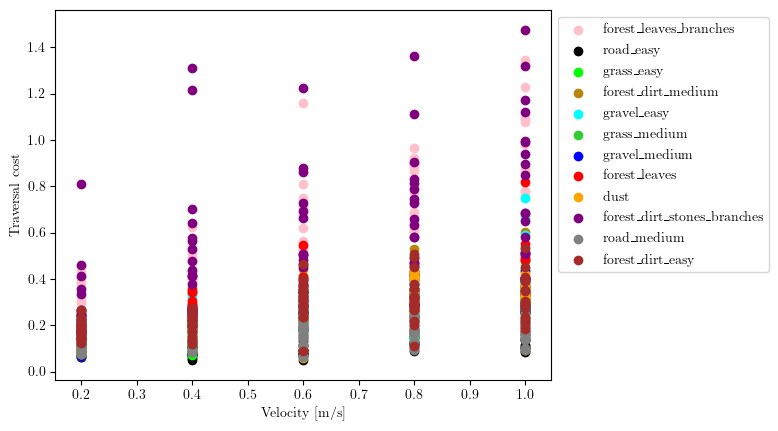

In [15]:
# Display the traversal costs
cost_graph = traversalcost.utils.display_traversal_costs(costs_df)

In [ ]:
df_filtered = costs_df[costs_df['linear_velocity'] == 1.0]
df_filtered.groupby(['terrain_class']).mean()


## Generate a log directory

In [ ]:
# Get the learning parameters table
params_table = parameters_table(dataset=params.siamese.DATASET,
                                learning_params=LEARNING_PARAMS)

# Set the path to the results directory
if params.siamese.LOG_DIR:
    results_directory = "logs/_" +\
                        params.siamese.LOG_DIR
else:
    results_directory = "logs/_" +\
                        datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
                        
# Generate the log directory
generate_log(dataset_directory=params.siamese.DATASET,
             results_directory=results_directory,
             test_loss=test_loss,
             test_accuracy=test_accuracy,
             parameters_table=params_table,
             model=model,
             loss_values=loss_values,
             accuracy_values=accuracy_values)
costs_df.to_csv(results_directory + "/costs_df.csv", sep=',', encoding='utf-8')
np.save(results_directory + "/mean" ,costs_df['cost'].mean())